In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import electiondata as e

from datetime import datetime, timedelta

In [2]:
polls = pd.read_csv(
    "https://projects.fivethirtyeight.com/2021-ca-recall-data/ca_recall_polls_2021.csv"
)
polls = polls.loc[(polls.candidate_name == "Keep") | (polls.candidate_name == "Remove")]
del polls["tracking"]
del polls["pct"]
polls = e.columns_for_variable(
    polls, values_are="house_adjusted_pct", columns_for="candidate_name"
)
polls.columns = [x[1] or x[0] for x in polls.columns]
polls["time"] = polls.apply(
    lambda x: np.mean(
        [
            (datetime.strptime(d, "%m/%d/%Y") - datetime(2021, 9, 14)).days
            for d in [x.startdate, x.enddate]
        ]
    ),
    axis=1,
)

In [8]:
k = 40
# plt.scatter(polls.time, polls.influence / polls.weight)
# plt.plot(np.arange(-k, 0), 1 + np.arange(-k, 0) / k)

In [17]:
times = np.arange(-90, 1)
smoothing = 3


def compute(remove_surveyusa):
    remain = []
    recall = []
    for time in times:
        within_time = polls[(polls.time <= time) & (polls.time > time - k)]
        if remove_surveyusa:
            within_time = within_time[within_time.pollster != "SurveyUSA"]
        influence = within_time.weight * (1 + (within_time.time - time) / k)
        remain.append((within_time.Keep * influence).sum() / influence.sum())
        recall.append((within_time.Remove * influence).sum() / influence.sum())
    margin = np.array(remain) - recall
    margin = [margin[0]] * smoothing + list(margin)
    margin = np.array(margin)
    margin = np.mean(
        [
            margin[i : margin.size - (smoothing - i)]
            for i in range(smoothing + 1)
        ],
        axis=0,
    )
    return margin

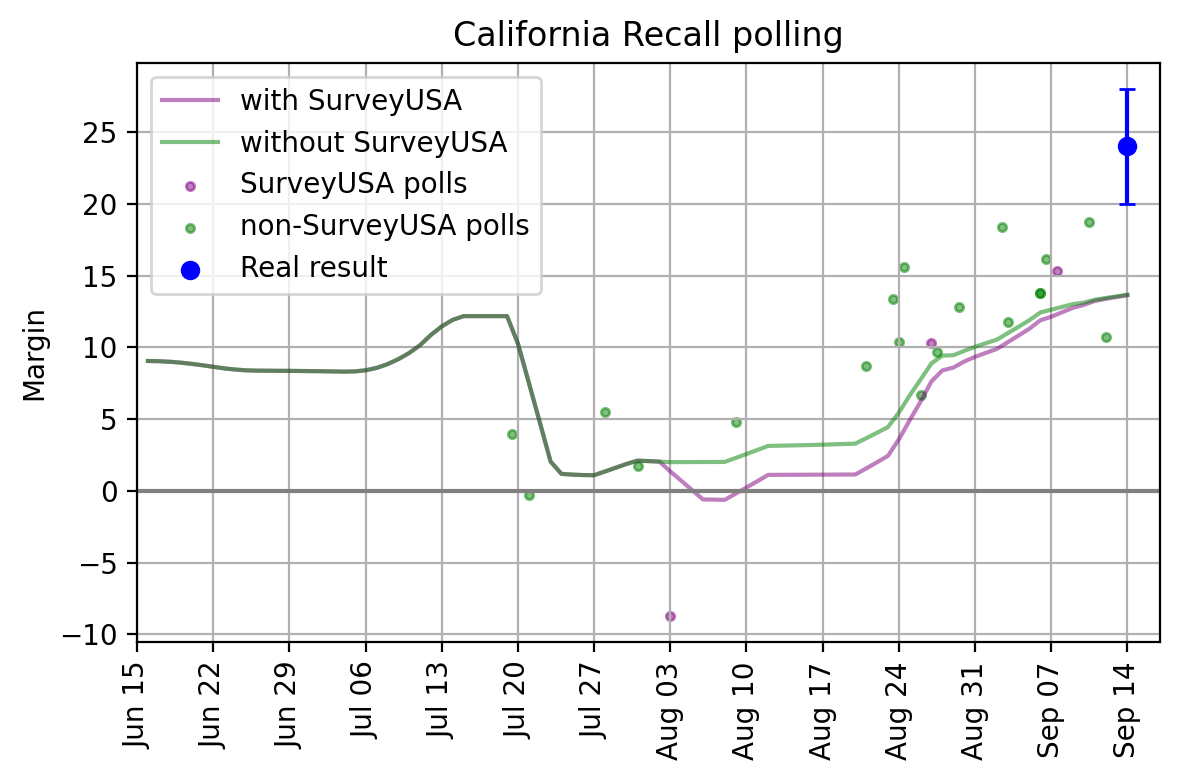

In [18]:
fig = plt.figure(dpi=200)
fig.patch.set_facecolor('#ffffff')
margin = compute(False)
plt.plot(times, margin, label="with SurveyUSA", color="purple", alpha=0.5)
margin = compute(True)
plt.plot(times, margin, label="without SurveyUSA", color="green", alpha=0.5)
plt.axhline(0, color="grey")
plt.ylabel("Margin")


def plot(polls, **kwargs):
    plt.scatter(polls.time, polls.Keep - polls.Remove, **kwargs)


plot(
    polls[polls.pollster == "SurveyUSA"],
    color="purple",
    alpha=0.5,
    marker=".",
    label="SurveyUSA polls",
)
plot(
    polls[polls.pollster != "SurveyUSA"],
    color="green",
    alpha=0.5,
    marker=".",
    label="non-SurveyUSA polls",
)
plt.xlim(times.min(), 3)
xticks = -np.arange(0, 7 - times.min(), 7)
plt.xticks(
    xticks,
    [
        datetime.strftime(datetime(2021, 9, 14) + timedelta(days=int(x)), "%b %d")
        for x in xticks
    ],
    rotation=90,
)
plt.scatter(0, 24, color="blue", label="Real result")
plt.errorbar(0, 24, 4, capsize=3, color="blue")
plt.title("California Recall polling")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("surveyusa-bad.png", dpi=600)
plt.show()